In [1]:
#Install fastkaggle if not available
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle
    
from fastkaggle import *  

In [2]:
comp = 'paddy-disease-classification'
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')
from fastai.vision.all import *

C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


we need to be able to iterate much more quickly. What we can do is to simply resize all the images to half their height and width -- which reduces their number of pixels 4x. This should mean an around 4x increase in performance for training small models.

Luckily, fastai has a function which does exactly this, whilst maintaining the folder structure of the data: resize_images.

In [3]:
trn_path = Path(path/'sml')

In [4]:
resize_images(path/'train_images', dest=trn_path, max_size=256, recurse=True)

This will give us 192x256px images. Let's take a look:

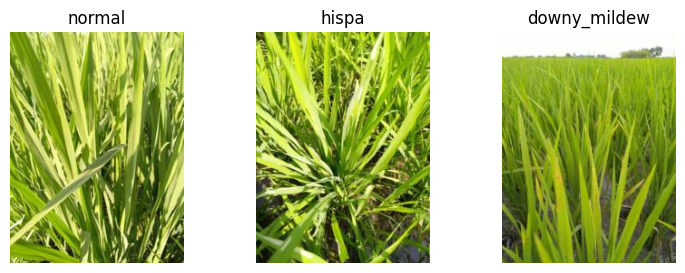

In [7]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2,
    item_tfms=Resize((256,192)))

dls.show_batch(max_n=3)

we'll be experimenting with a few different architectures and image processing approaches (item and batch transforms). In order to make this easier, we'll put our modeling steps together into a little function which we can pass the architecture, item transforms, and batch transforms to:

In [5]:
def train(arch, item, batch, epochs=5, bs=8):
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2, item_tfms=item, batch_tfms=batch, bs=bs)
    learn = vision_learner(dls, arch, metrics=error_rate).to_fp16()
    learn.fine_tune(epochs, 0.01)
    return learn

In [9]:
learn = train('resnet26d', item=Resize(192),
              batch=aug_transforms(size=128, min_scale=0.75))

epoch,train_loss,valid_loss,error_rate,time
0,1.951439,1.559871,0.502162,02:11


epoch,train_loss,valid_loss,error_rate,time
0,1.263894,0.940972,0.309467,00:55
1,1.018112,0.690974,0.216723,00:55
2,0.725204,0.453406,0.143681,00:55
3,0.528311,0.381739,0.121576,00:55
4,0.433180,0.355353,0.110043,00:55


A ConvNeXt model

In [7]:
arch = 'convnext_small_in22k'

In [8]:
learn = train(arch, item=Resize(192, method='squish'),
              batch=aug_transforms(size=128, min_scale=0.5))

C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.675465,0.996795,0.322922,08:37


epoch,train_loss,valid_loss,error_rate,time
0,0.978446,0.549298,0.179241,11:16
1,0.780632,0.553523,0.182124,11:10
2,0.328917,0.314654,0.104277,11:09
3,0.261937,0.187407,0.055742,14:30
4,0.150684,0.158408,0.051418,11:29


In [9]:
learn = train(arch, item=Resize((256,192), method=ResizeMethod.Pad, pad_mode=PadMode.Zeros),
      batch=aug_transforms(size=(171,128), min_scale=0.75), bs=16)

C:\Users\vicky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\timm\models\_factory.py:138: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(


epoch,train_loss,valid_loss,error_rate,time
0,1.613875,0.982242,0.282076,08:15


epoch,train_loss,valid_loss,error_rate,time
0,0.828074,0.521784,0.184527,12:27
1,0.601752,0.419522,0.131667,12:57
2,0.331363,0.233247,0.073042,1:13:34
3,0.181359,0.162758,0.046612,12:44
4,0.170695,0.144477,0.039885,12:48


To make the predictions even better, we can try test time augmentation (TTA),

Before trying that out, we'll first see how to check the predictions and error rate of our model without TTA:

In [10]:
valid = learn.dls.valid
preds,targs = learn.get_preds(dl=valid)

In [ ]:
error_rate(preds, targs)

TensorBase(0.0399)

Here's what our data augmentation is doing -- if you look carefully, you can see that each image is a bit lighter or darker, sometimes flipped, zoomed, rotated, warped, and/or zoomed:

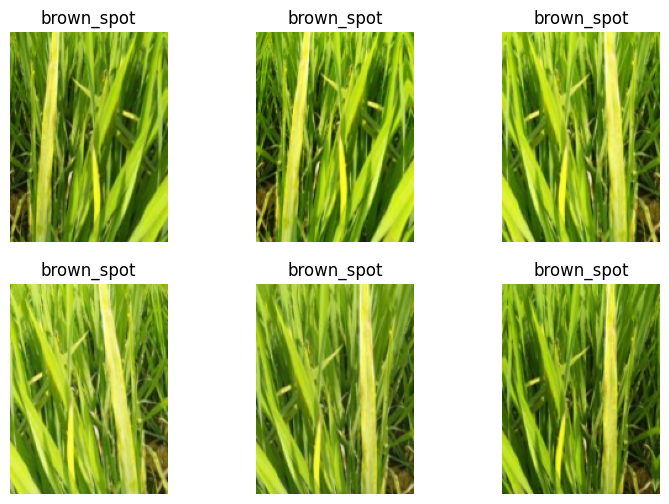

In [12]:
learn.dls.train.show_batch(max_n=6, unique=True)

If we call tta() then we'll get the average of predictions made for multiple different augmented versions of each image, along with the unaugmented original:

In [13]:
tta_preds,_ = learn.tta(dl=valid)

In [14]:
error_rate(tta_preds, targs)

TensorBase(0.0370)

Submission

In [15]:
tst_files = get_image_files(path/'test_images').sorted()
tst_dl = learn.dls.test_dl(tst_files)

Next, do TTA on that test set:

In [16]:
preds,_ = learn.tta(dl=tst_dl)

We need to indices of the largest probability prediction in each row, since that's the index of the predicted disease. argmax in PyTorch gives us exactly that:

In [17]:
idxs = preds.argmax(dim=1)

Now we need to look up those indices in the vocab

In [18]:
vocab = np.array(learn.dls.vocab)
results = pd.Series(vocab[idxs], name="idxs")

In [19]:
ss = pd.read_csv(path/'sample_submission.csv')
ss['label'] = results
ss.to_csv(path/'subm.csv', index=False)


In [20]:
if not iskaggle:
    from kaggle import api
    api.competition_submit_cli(path/'subm.csv', 'Pat2 - convnext small 256x192 12 epochs tta', comp)

100%|██████████| 73.5k/73.5k [00:01<00:00, 43.7kB/s]
